In [1]:
# Needed libraries

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
from bokeh.plotting import figure, save,show
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
from bokeh.io import output_notebook,output_file
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap

from keplergl import KeplerGl
import geopandas as gpd

from matplotlib import cm

In [2]:
# Load the country history
#raw_df = pd.read_csv('../../../../og_data/ST_with_country.csv', parse_dates=['ts'],\
#                       low_memory=False)

raw_df = pd.DataFrame()

flights_to_add = ['N139LB', 'N166LB', 'N191LB', 'N211LB', 'N221LB', 'N225LB', 'N226LB', 'N228LB', 'N234LB',
                   'N235LB', 'N238LB', 'N252LB', 'N253LB', 'N271LB', 'N329LB', 'N789LB']

for flight in flights_to_add:

    aux = pd.read_csv('../../../../og_data/Country/' + flight + '-country.csv', parse_dates=['ts'], \
                       low_memory=False)
    
    raw_df = raw_df.append(aux)
    

In [3]:
raw_df

,ts,aircraft_id,alt,speed,Direction,registration_id,lat,lon,country,country_code
0,2017-12-06 01:26:44+00:00,HBAL048,40025,32,141,N139LB,40.535568,-117.813049,United States of America,USA
1,2017-12-06 01:26:51+00:00,HBAL048,40050,32,139,N139LB,40.534882,-117.812256,United States of America,USA
2,2017-12-06 01:26:57+00:00,HBAL048,40100,33,136,N139LB,40.534149,-117.811394,United States of America,USA
3,2017-12-06 01:27:03+00:00,HBAL048,40125,33,135,N139LB,40.533554,-117.810608,United States of America,USA
4,2017-12-06 01:28:09+00:00,HBAL048,40300,35,137,N139LB,40.525818,-117.800964,United States of America,USA
...,...,...,...,...,...,...,...,...,...,...
198609,2020-05-04 08:29:42+00:00,HBAL043,61400,18,288,N789LB,-3.685401,-83.218498,NaN,NaN
198610,2020-05-04 08:36:10+00:00,HBAL043,61400,17,300,N789LB,-3.671482,-83.247719,NaN,NaN
198611,2020-05-04 08:37:46+00:00,HBAL043,61400,17,296,N789LB,-3.667804,-83.254539,NaN,NaN
198612,2020-05-04 09:31:52+00:00,HBAL043,61300,17,276,N789LB,-3.589142,-83.494980,NaN,NaN


In [4]:
raw_df.speed.max()

746

In [5]:
bl_countries = raw_df[raw_df['country'].notnull()]

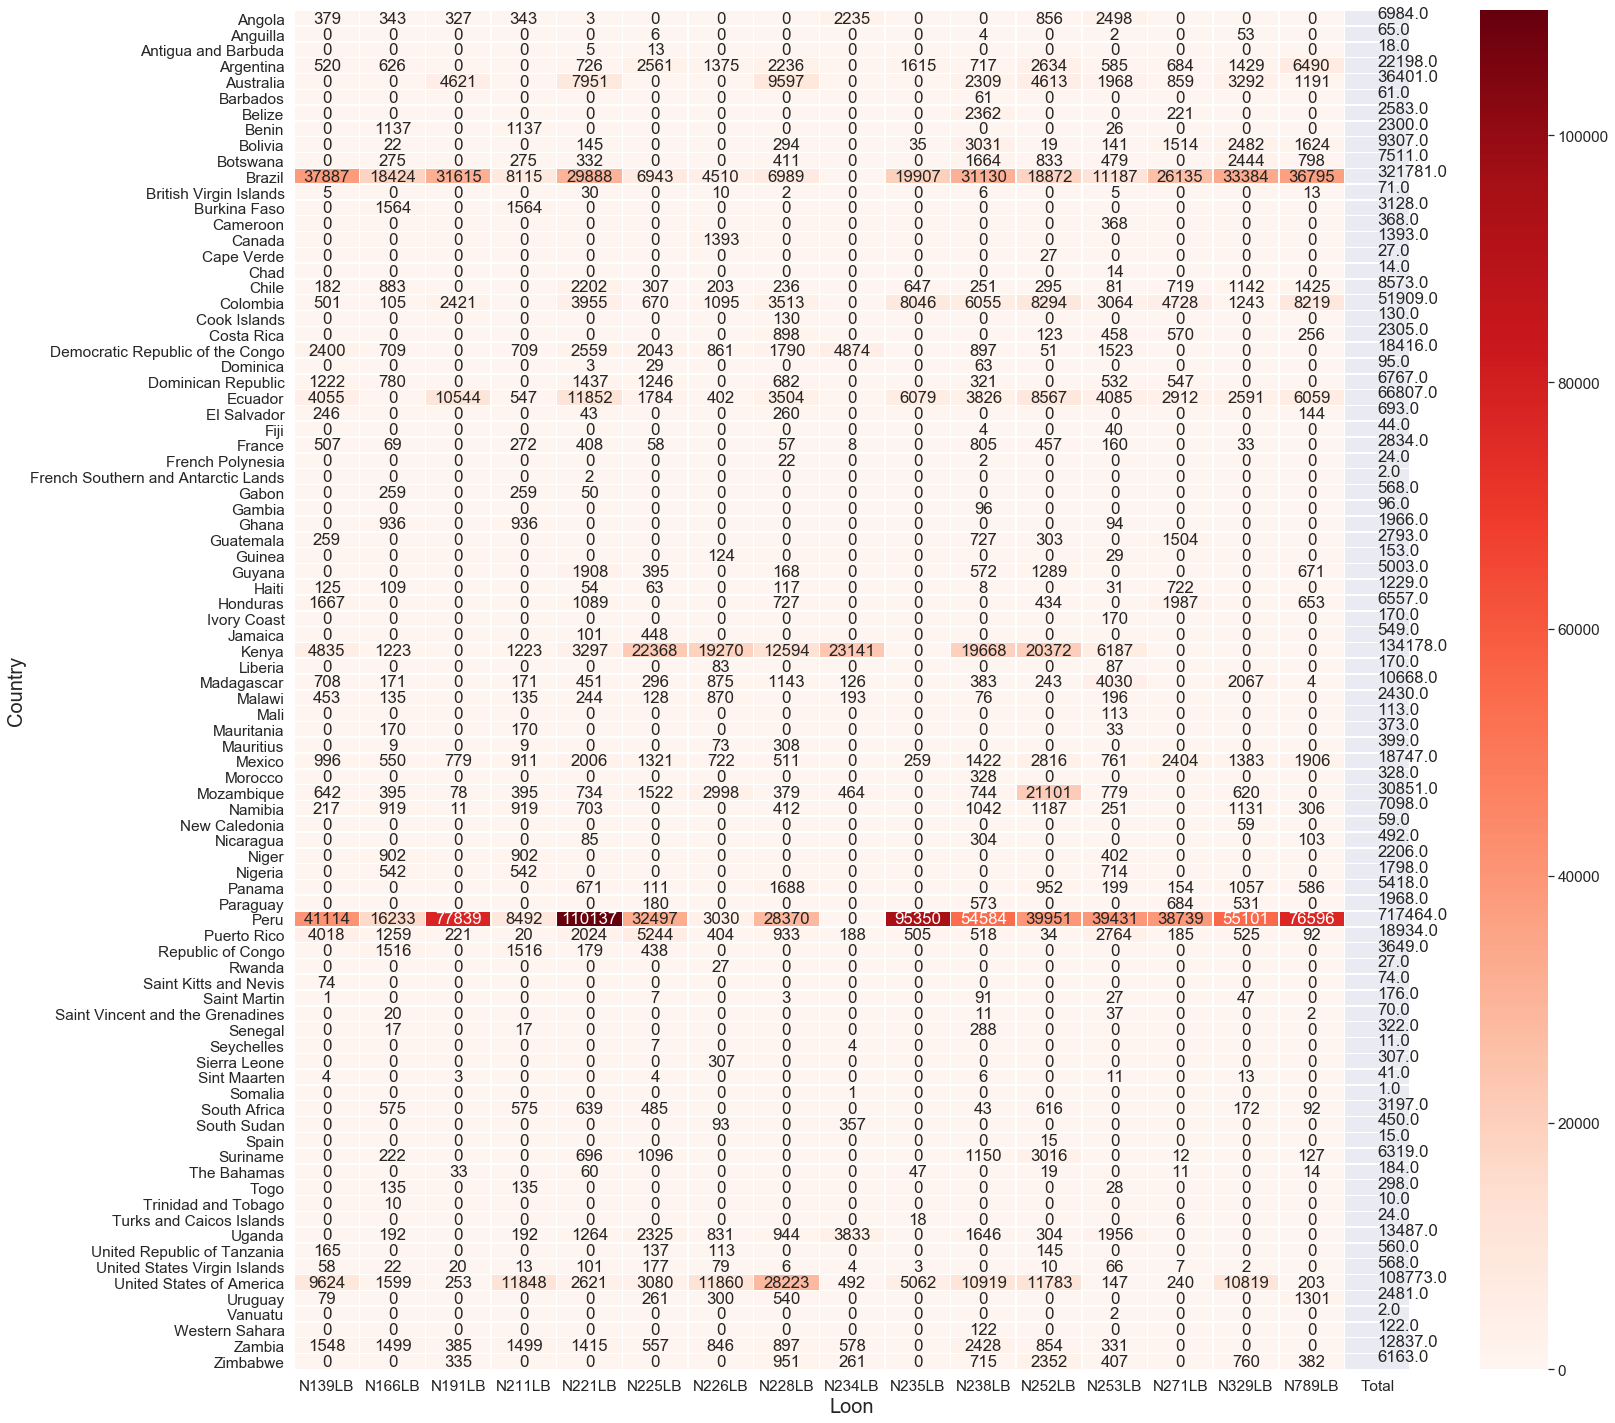

In [6]:
heatmap_df = bl_countries.groupby(['registration_id', 'country'])['ts'].count().reset_index()

# Reshape the data to adapt it to the heatmap
heatmap_df = heatmap_df.pivot(index='country', columns='registration_id', values='ts')
heatmap_df = heatmap_df.fillna(0)

heatmap_df['Total'] = heatmap_df.iloc[:, 0:len(heatmap_df.columns)].sum(axis=1)
mask = np.zeros((len(heatmap_df), len(heatmap_df.columns)))
mask[:,len(heatmap_df.columns)-1] = True


# Set the width and height of the figure
plt.figure(figsize=(25,25))
sns.set(font_scale=1.4)

ax = sns.heatmap(data=heatmap_df, mask=mask, vmin=heatmap_df.values[:,:len(heatmap_df.columns)-1].ravel().min(),\
                         vmax=heatmap_df.values[:,:len(heatmap_df.columns)-1].ravel().max(),\
                         cmap='Reds', linewidths=.5, annot=True, fmt='g')

for (j,i), label in np.ndenumerate(heatmap_df.values):
    if i == len(heatmap_df.columns)-1:
        ax.text(i+0.5, j+0.5, label)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

b = plt.xlabel("Loon", fontsize=20)
b = plt.ylabel("Country", fontsize=20)


In [10]:
#Create a basemap 
map = KeplerGl(height=700, width=800)#show the map
map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(height=700)

In [15]:
# Create a geodataframe
aircraft_ids = bl_countries.loc[bl_countries.country.isin(["Spain","France"])].aircraft_id

kepler_bl = bl_countries.loc[bl_countries.aircraft_id.isin(aircraft_ids)]
gdf = gpd.GeoDataFrame(kepler_bl, geometry=gpd.points_from_xy(kepler_bl.lon, kepler_bl.lat))

map.add_data(data=gdf, name="loon traces")

In [7]:
bl_countries.country.nunique()

86

In [8]:
# Top visited countries
heatmap_df.sort_values('Total', ascending=False).head(10)

registration_id,N139LB,N166LB,N191LB,N211LB,N221LB,N225LB,N226LB,N228LB,N234LB,N235LB,N238LB,N252LB,N253LB,N271LB,N329LB,N789LB,Total
country,,,,,,,,,,,,,,,,,
Peru,41114.0,16233.0,77839.0,8492.0,110137.0,32497.0,3030.0,28370.0,0.0,95350.0,54584.0,39951.0,39431.0,38739.0,55101.0,76596.0,717464.0
Brazil,37887.0,18424.0,31615.0,8115.0,29888.0,6943.0,4510.0,6989.0,0.0,19907.0,31130.0,18872.0,11187.0,26135.0,33384.0,36795.0,321781.0
Kenya,4835.0,1223.0,0.0,1223.0,3297.0,22368.0,19270.0,12594.0,23141.0,0.0,19668.0,20372.0,6187.0,0.0,0.0,0.0,134178.0
United States of America,9624.0,1599.0,253.0,11848.0,2621.0,3080.0,11860.0,28223.0,492.0,5062.0,10919.0,11783.0,147.0,240.0,10819.0,203.0,108773.0
Ecuador,4055.0,0.0,10544.0,547.0,11852.0,1784.0,402.0,3504.0,0.0,6079.0,3826.0,8567.0,4085.0,2912.0,2591.0,6059.0,66807.0
Colombia,501.0,105.0,2421.0,0.0,3955.0,670.0,1095.0,3513.0,0.0,8046.0,6055.0,8294.0,3064.0,4728.0,1243.0,8219.0,51909.0
Australia,0.0,0.0,4621.0,0.0,7951.0,0.0,0.0,9597.0,0.0,0.0,2309.0,4613.0,1968.0,859.0,3292.0,1191.0,36401.0
Mozambique,642.0,395.0,78.0,395.0,734.0,1522.0,2998.0,379.0,464.0,0.0,744.0,21101.0,779.0,0.0,620.0,0.0,30851.0
Argentina,520.0,626.0,0.0,0.0,726.0,2561.0,1375.0,2236.0,0.0,1615.0,717.0,2634.0,585.0,684.0,1429.0,6490.0,22198.0


In [9]:
# Let's check the countries where the loons have stayed

episode_start_times = bl_countries.loc[bl_countries.stationary == True]\
                                    .groupby(['registration_id', 'cluster', 'episode'])['ts'].min().reset_index()

episode_end_times = bl_countries.loc[bl_countries.stationary == True]\
                                    .groupby(['registration_id', 'cluster', 'episode'])['ts'].max().reset_index()

client_countries = bl_countries.loc[bl_countries.stationary == True]\
                                    .groupby(['registration_id', 'cluster', 'episode'])['country']\
                                        .agg(lambda x:x.value_counts().index[0]).reset_index()

client_countries['service_start'] = episode_start_times['ts']
client_countries['service_end'] = episode_end_times['ts']
client_countries['service_duration'] = client_countries['service_end'] - client_countries['service_start']

client_countries = client_countries.sort_values('service_duration', ascending=False)

client_countries


AttributeError: 'DataFrame' object has no attribute 'stationary'

In [ ]:
# Now we can get some insights
client_countries.groupby()

In [ ]:
episode_end_times

In [ ]:
episode_country